# Integrating a production system with BugDoc

In order to link BugDoc with a working production system but without interfering with that production system, we need to perform several steps. We outline them below along with a running example.

The running example takes inputs in a streaming fashion from two data sources through Kubernetes.
It runs these through a simple three stage pipeline and delivers a result.
That result is one of the data sources for the next time period, which for us will be a day.

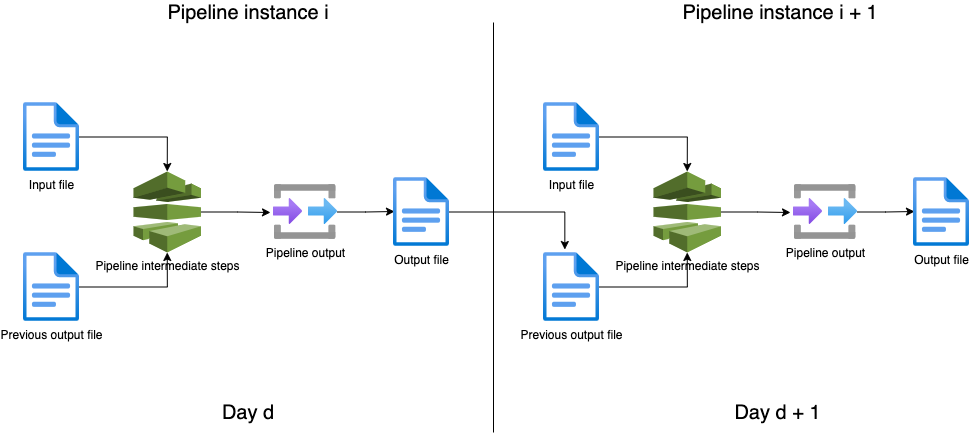

## Creating a sandbox 

For BugDoc to work, every run of a particular instance should give the same success/failure result. That's our definition of determinism. This is not always possible because of race conditions, but to make it at least likely, we have to preserve the instance of each input file for each day as well as the parameter settings for that day. We call that a **snapshot**.

So every day's inputs constitutes a snapshot.
The iterations performed by BugDoc will take parameters and file instances
of one or more snapshots and will generate new pipeline instances. We need to run each pipeline instance in a sandbox environment.



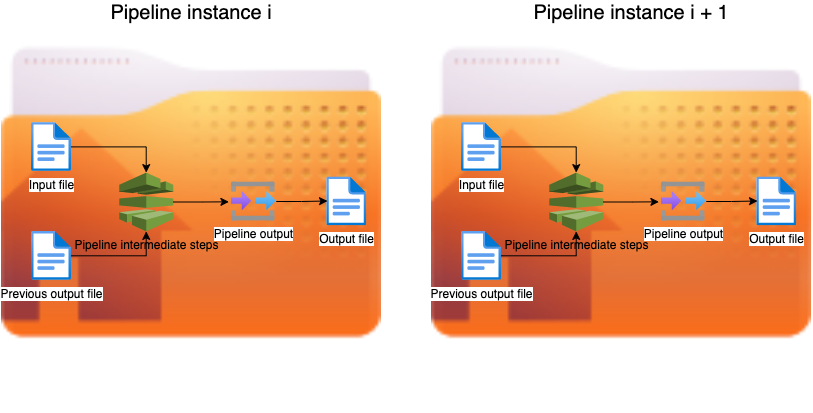

## Evaluating the pipeline

The pipeline needs to be rebuilt in the sandbox with an evaluation function attached
on the output to say whether a given execution through the pipeline
succeeded or failed. Please note that the evaluation function can represent an application-dependent assessment of the output or it can capture when the pipeline execution crashed.


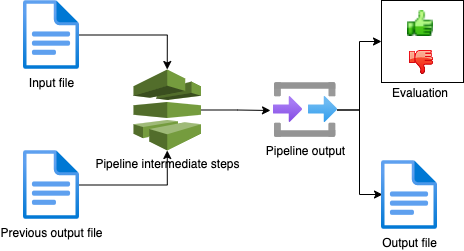

## Execution History
BugDoc keeps track of the provenance of each execution -- parameter settings,
data inputs, data outputs, and result of the evaluation function. The following utility [function](api.html#bugdoc.utils.utils.record_pipeline_run) stores the data corresponding to a pipeline instance $i$ as can be seen in this API [example](auto_examples/api_interface.html#sphx-glr-auto-examples-api-interface-py).

In [ ]:
from bugdoc.utils.utils import record_pipeline_run

If the pipeline to be debugged has a previous execution that BugDoc should consider before generating new instances, these should be stored in a file of the same name as the pipeline entry point dicussed in the next section, either manually or by calling ```record_pipeline_run``` as illustrated below:  

In [ ]:
PIPELINE_ENTRY_POINT = "my_pipeline.log"
PIPELINE_PARAMETERS = ['p1', 'p2', 'p3']
PIPELINE_INSTANCE_HISTORY = [
    {
        "values": ['p1v1', 1, 1.0],
        "result": True
    },
    {
        "values": ['p1v2', 2, 2.0],
        "result": False
    }
]
for instance in PIPELINE_INSTANCE_HISTORY:
    record_pipeline_run(PIPELINE_ENTRY_POINT, instance["values"],PIPELINE_PARAMETERS,instance["result"])

This will create the file ```my_pipeline.log```, if it does not exist, and add the following content to it:
```
{"p1": "p1v1", "p2": 1, "p3": 1.0, "result": "True"}
{"p1": "p1v2", "p2": 2, "p3": 2.0, "result": "False"}
```

##  Connect with BugDoc and execute the pipeline 
The sandbox must receive an instance configuration from BugDoc, run the pipeline and send
back success or failure. The [Example](auto_examples/index.html) section shows how to establish connections to exchange messages with BugDoc, call any proprietary API to execute and evaluate the pipeline, and save instance information. The following shows the minimal steps to define an interface between the BugDoc command-line tool and an arbitrary pipeline execution system.

BugDoc requires a ```JSON``` file with the following fields:
- An entry point to the pipeline: ```entry_point```.
- The python module (accessible by the python path) containing the function to run the pipeline: ```python_module```.
- The function to run a pipeline instance: ```run```.
- A list of parameters, each one consisting of a name and a list of values: ```parameters```.
    - The name of the parameter: ```name```.
    - The values that each parameter can take: ```values```.

For example, ```my_pipeline_conf.json```:
```
{
  "entry_point": "my_pipeline",
  "python_module": "my_api_example",
  "run": "execute_pipeline",
  "parameters": [
    {
      "name": "p1",
      "values": [
        "p1v1",
        "p1v2",
        "p1v3"
        ]
    },
    {
      "name": "p2",
      "values": [1, 2, 3]
    },
    {
      "name": "p3",
      "values": [1.0, 2.0, 3.0]
    },
  ]
  }
```

BugDoc's command-line interface is run by the following command:
```
    $ bugdoc-cli --file my_pipeline_conf.json
```

The root causes are written to the ```my_pipeline.result``` file, based on the ```entry_point``` field. 

Note that not all parameter-values need to be defined in the ```my_pipeline_conf.json``` file, BugDoc will also consider any value used in the pipeline instances present in the ```my_pipeline.log``` file. However, the name of the parameters should be stated. For additional optional settings, please visit BugDoc-CLI's info [page](client.html).